In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
dates = os.listdir("/media/ubuntu/sda/data/mouse6/output/threshold_number_test/5000")

cluster_inf = pd.DataFrame()
spike_inf = pd.DataFrame()
waveform_mean = pd.DataFrame()

for date in dates:
    cluster_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output/threshold_number_test/5000/{date}/cluster_inf.tsv', sep = '\t').iloc[:, 1:]
    cluster_inf_temp['date'] = date
    cluster_inf = pd.concat((cluster_inf, cluster_inf_temp), axis= 0)

    spike_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output/threshold_number_test/5000/{date}/spike_inf.tsv', sep = "\t").iloc[:, 1:]
    spike_inf_temp['date'] = date
    spike_inf = pd.concat((spike_inf, spike_inf_temp), axis=0)

    waveform_mean_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output/threshold_number_test/5000/{date}/waveform_mean.tsv', sep = "\t").iloc[:, 1:]
    waveform_mean_temp.columns = waveform_mean_temp.columns + f"_{date}"
    waveform_mean = pd.concat((waveform_mean, waveform_mean_temp), axis=1)


del waveform_mean_temp, spike_inf_temp, cluster_inf_temp

In [36]:
date_order = ['021322', '022522', '031722', '042422', 
              '052422', '062422', '072322', '082322', 
              '092422', '102122', '112022', '122022', 
              '012123', '022223', '032123', '042323']

In [3]:
threshold = np.arange(1, 15, 1)
num_neuron = []
for num in threshold:
    cluster_inf['Neuron'] = None
    cluster_inf.iloc[0, 28] = 1
    neuron_inf = pd.DataFrame(cluster_inf.iloc[0, :]).T
    neuron = 1
    for i in range(1, len(cluster_inf)):
        found = False
        for j in range(len(neuron_inf)):
            if (abs(cluster_inf.iloc[i, 22] - neuron_inf.iloc[j, 22]) <= num) and (abs(cluster_inf.iloc[i, 23] - neuron_inf.iloc[j, 23]) <= num):
                cluster_inf.iloc[i, 28] = neuron_inf.iloc[j, 28]
                found = True
                break
        if not found:
            neuron += 1
            cluster_inf.iloc[i,28] = neuron
            neuron_inf = pd.concat((neuron_inf, pd.DataFrame(cluster_inf.iloc[i, :]).T), axis=0)

    neurons_with_count_gt_16 = cluster_inf['Neuron'].value_counts()
    neuron_values = neurons_with_count_gt_16[neurons_with_count_gt_16 >= 13].index.tolist()
    num_neuron.append(len(neuron_values))


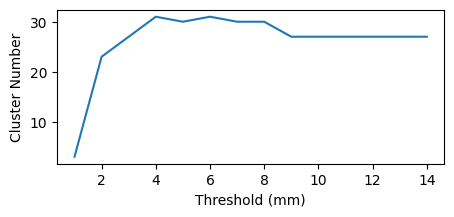

In [5]:
plt.figure(figsize=(5, 2))
sns.lineplot(x = threshold,
                y = num_neuron)
plt.xlabel("Threshold (mm)")
plt.ylabel("Cluster Number")
plt.show()

In [4]:
num = 6
cluster_inf['Neuron'] = None
cluster_inf.iloc[0, 28] = 1
neuron_inf = pd.DataFrame(cluster_inf.iloc[0, :]).T
neuron = 1
for i in range(1, len(cluster_inf)):
    found = False
    for j in range(len(neuron_inf)):
        if (abs(cluster_inf.iloc[i, 22] - neuron_inf.iloc[j, 22]) <= num) and (abs(cluster_inf.iloc[i, 23] - neuron_inf.iloc[j, 23]) <= num):
            cluster_inf.iloc[i, 28] = neuron_inf.iloc[j, 28]
            found = True
            break
    if not found:
        neuron += 1
        cluster_inf.iloc[i,28] = neuron
        neuron_inf = pd.concat((neuron_inf, pd.DataFrame(cluster_inf.iloc[i, :]).T), axis=0)

neurons_with_count_gt_16 = cluster_inf['Neuron'].value_counts()
neuron_values = neurons_with_count_gt_16[neurons_with_count_gt_16 >= 13].index.tolist()

In [5]:
num = 1
neuron_cluster_dict = {}
for neuron in neuron_values:
    temp = cluster_inf[cluster_inf['Neuron'] == neuron]
    filter_cluster = temp.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
    waveform_mean_temp = waveform_mean.loc[:, filter_cluster]

    from sklearn.cluster import DBSCAN
    from sklearn.decomposition import PCA


    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(waveform_mean_temp.T)

    eps = 100
    min_samples = 1

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(principal_components)

    #plt.Figure(figsize=(5, 5))
    #sns.scatterplot(x = principal_components[:, 0],
    #            y = principal_components[:, 1],
    #            hue=dbscan.labels_)
    #plt.title(neuron)
    #plt.show()

    filter_cluster = pd.DataFrame(filter_cluster).reset_index(drop=True)
    filter_cluster = pd.concat((pd.DataFrame(filter_cluster), pd.DataFrame(dbscan.labels_)), axis=1)
    filter_cluster.columns = ['cluster_date', 'dbscan_labels']
    for i in filter_cluster['dbscan_labels'].value_counts().index:
        neuron_cluster_dict[f'Neuron_{num}'] = filter_cluster.loc[filter_cluster['dbscan_labels'] == i, 'cluster_date'].tolist()
        num += 1

In [8]:
len(neuron_cluster_dict)

62

In [6]:
neuron_cluster_dict = {key: value for key, value in neuron_cluster_dict.items() if len(set([item.split('_')[1] for item in value])) >= 13}

In [7]:
cluster_inf['cluster_date'] = cluster_inf.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
cluster_inf = cluster_inf[cluster_inf['cluster_date'].isin([item for sublist in neuron_cluster_dict.values() for item in sublist])]
for key, item in neuron_cluster_dict.items():
    cluster_inf.loc[cluster_inf['cluster_date'].isin(item), 'Neuron'] = key 

spike_inf['cluster_date'] = spike_inf.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
spike_inf = spike_inf[spike_inf['cluster_date'].isin([item for sublist in neuron_cluster_dict.values() for item in sublist])]
for key, item in neuron_cluster_dict.items():
    spike_inf.loc[spike_inf['cluster_date'].isin(item), 'Neuron'] = key 

In [8]:
cluster_inf['Neuron_index'] = cluster_inf['Neuron'].str.extract(r'Neuron_(\d+)').astype(int)
cluster_inf = cluster_inf.sort_values(by='Neuron_index')
cluster_inf['Neuron'] = 'Neuron_' + (cluster_inf['Neuron_index'].rank(method='dense').astype(int)).astype(str)

spike_inf['Neuron_index'] = spike_inf['Neuron'].str.extract(r'Neuron_(\d+)').astype(int)
spike_inf = spike_inf.sort_values(by='Neuron_index')
spike_inf['Neuron'] = 'Neuron_' + (spike_inf['Neuron_index'].rank(method='dense').astype(int)).astype(str)

In [9]:
cluster_inf['neuron_date'] = cluster_inf.apply(lambda row: f"{row['Neuron']}_{row['date']}", axis=1)
spike_inf['neuron_date'] = spike_inf.apply(lambda row: f"{row['Neuron']}_{row['date']}", axis=1)

In [10]:
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
with PdfPages('cluster_view.pdf') as pdf:
    for neuron in sorted(cluster_inf['Neuron'].unique(), key=lambda x: int(x.split('_')[1])):
        temp = cluster_inf[cluster_inf['Neuron'] == neuron]
        waveform_mean_temp = waveform_mean.loc[:, temp['cluster_date'].tolist()]

        similarity = np.zeros((waveform_mean_temp.shape[1], waveform_mean_temp.shape[1]))
        for i in range(waveform_mean_temp.shape[1]):
            for j in range(waveform_mean_temp.shape[1]):
                similarity[i, j], _ = pearsonr(waveform_mean_temp.iloc[:, i], waveform_mean_temp.iloc[:, j])
        similarity = similarity.flatten()

        cluster_num = len(temp['neuron_date'].value_counts().index)
        blue_palette = sns.color_palette("Blues", n_colors=waveform_mean_temp.shape[1])

        fig, ax = plt.subplots(figsize=(6, 4))
        for i in range(waveform_mean_temp.shape[1]):
            sns.lineplot(x = range(61),
                        y = waveform_mean_temp.iloc[:, i],
                        color=blue_palette[i],
                        ax=ax)
        axins = inset_axes(ax, width="20%", height="30%", loc='lower right', bbox_to_anchor=(-0.03, 0.05, 1, 1), bbox_transform=ax.transAxes)    
        sns.histplot(similarity, color='red', ax=axins, edgecolor = None)
        axins.set_yticks([])
        axins.set_ylabel("")
        axins.set_title("Similarity", fontsize=9)
        axins.tick_params(axis='both', which='major', labelsize=8)

        ax.set_ylabel("Amplitude")
        ax.set_xticks([])
        ax.set_title(neuron)
        ax.text(0.01, 0.95, f'Cluster Number: {cluster_num}', transform=ax.transAxes, fontsize=10, color='black', ha='left')
        pdf.savefig(fig)
        plt.close(fig)


In [14]:
spike_inf.to_csv("spike_inf_13.tsv", sep = '\t')
cluster_inf.to_csv("clusteri_inf_13.tsv", sep = '\t')

In [11]:
select_neurons = ['Neuron_1', 'Neuron_2', 'Neuron_3', "Neuron_4",
                  'Neuron_7', 'Neuron_9', 'Neuron_11', 'Neuron_14',
                  'Neuron_15', 'Neuron_16', "Neuron_17", "Neuron_18",
                  "Neuron_19", "Neuron_20", 'Neuron_22', 'Neuron_23',
                  "Neuron_24", "Neuron_25"]

In [12]:
spike_inf = spike_inf[spike_inf['Neuron'].isin(select_neurons)]
cluster_inf = cluster_inf[cluster_inf['Neuron'].isin(select_neurons)]

In [20]:
neuron_date_dict = {}
for neuron in sorted(cluster_inf['Neuron'].unique(), key=lambda x: int(x.split('_')[1])):
    temp = cluster_inf[cluster_inf['Neuron'] == neuron]
    neuron_date_dict[neuron] = sorted(temp['date'].unique())

In [21]:
trigger_time = pd.read_csv("/media/ubuntu/sda/data/mouse6/output/01_get_trigger/trigger_time.tsv", sep = '\t').iloc[:, 1:]

In [26]:
from scipy.stats import  pearsonr
firing_rate_dict = {}
correlation_dict = {}

for date in spike_inf['date'].unique():
    spike_inf_temp = spike_inf[spike_inf['date'] == date]
    firing_rate_dict[date] = {}
    trigger_time_temp = trigger_time[trigger_time['date'] == int(date)]
    for image in trigger_time_temp['image'].unique():
        firing_rate_dict[date][image] = pd.DataFrame()
        trigger_time_temp_temp = trigger_time_temp[trigger_time_temp['image'] == image]
        for image_order in trigger_time_temp_temp['order'].sort_index().values.tolist():
            trigger_time_temp_temp_temp = trigger_time_temp_temp[trigger_time_temp_temp['order'] == image_order]
            temp = spike_inf_temp[(spike_inf_temp['time'] > int(trigger_time_temp_temp_temp['start'].values)) & (spike_inf_temp['time'] < int(trigger_time_temp_temp_temp['end'].values))]
            firing_rate_dict[date][image] = pd.concat((firing_rate_dict[date][image], pd.DataFrame(temp['Neuron'].value_counts()).sort_index()), axis=1)
        firing_rate_dict[date][image] = firing_rate_dict[date][image].fillna(0)

    correlation_dict[date] = {}
    for key in sorted(list(firing_rate_dict[date].keys())):
        num = firing_rate_dict[date][key].shape[1]
        correlation_dict[date][key] = np.zeros((num, num))
        for i in range(num):
            for j in range(num):
                correlation_dict[date][key][i, j], _ = pearsonr(firing_rate_dict[date][key].iloc[:, i].values.tolist(), firing_rate_dict[date][key].iloc[:, j].values.tolist())


In [27]:
outlier = []
for date in correlation_dict.keys():
    for image in range(1, 118):
        mean = (correlation_dict[date][image].sum(axis = 0)-1)/(len(correlation_dict[date][image]) - 1)
        for i in range(len(mean)):
            if mean[i] <= 0.6:
                outlier.append(f'{date}_{image}_{i}')

In [30]:
import pickle
with open('outlier.pkl', 'wb') as f:
    pickle.dump(outlier, f)

In [37]:
correlation_mean = pd.DataFrame()
for date in correlation_dict.keys():
    temp = []
    for image, df in correlation_dict[date].items():
        df = df.mean().mean()
        temp.append(df)
    correlation_mean = pd.concat((correlation_mean, pd.DataFrame(temp, columns=[date])),axis=1)

correlation_mean = correlation_mean[date_order]

In [43]:
with PdfPages("similarity_within_dates.pdf") as pdf:
    mean = correlation_mean.mean(axis=0)
    std = correlation_mean.std(axis=0)

    plt.figure(figsize=(6, 3))
    sns.lineplot(x = range(16),
                 y = mean,
                 color = 'black')
    sns.scatterplot(x = range(16),
                    y = mean,
                    size=30,
                    color = "black",
                    legend=False)
    plt.fill_between(x  = range(16), 
                     y1=mean - std,
                     y2=mean + std,
                     color = 'grey',
                     alpha = 0.2)
    plt.xticks([])
    plt.ylim(0, 1)
    plt.yticks([])
    pdf.savefig()
    plt.close()

In [43]:
with PdfPages('PV_similarity_tight.pdf') as pdf:
    for date in spike_inf['date'].unique():
        fig, axes = plt.subplots(9, 13, figsize=(26, 18))  
        axes = axes.flatten()  
        
        for key in sorted(list(firing_rate_dict[date].keys())):
            ax = axes[key-1]
            sns.heatmap(correlation_dict[date][key], cmap="coolwarm", vmax=1, vmin=0, ax=ax,cbar=False, xticklabels=False, yticklabels=False)
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(0.25)  
                spine.set_color('black')

        fig.suptitle(date, fontsize=30)
        fig.subplots_adjust(wspace=0, hspace=0)

        pdf.savefig(fig)
        plt.close(fig)

- between dates:

In [13]:
date_order = ['021322', '022522', '031722', '042422', 
              '052422', '062422', '072322', '082322', 
              '092422', '102122', '112022', '122022', 
              '012123', '022223', '032123', '042323']

In [45]:
filtered_neurons = pd.crosstab(cluster_inf['date'],
                cluster_inf['Neuron'])
filtered_neurons[filtered_neurons > 1] = 1
filtered_neurons = filtered_neurons.sum(axis=0)
filtered_neurons = filtered_neurons[filtered_neurons >=16].index.tolist()

firing_rate_date = {}
for i in range(1, 118):
    firing_rate_date[i] = pd.DataFrame()
    for date in date_order:
        temp = firing_rate_dict[date][i].loc[filtered_neurons, :].mean(axis = 1)
        firing_rate_date[i] = pd.concat((firing_rate_date[i], temp), axis=1)

In [46]:
correlation_date = {}
for key in range(1, 118):
    num = 16
    correlation_date[key] = np.zeros((16, 16))
    for i in range(16):
        for j in range(16):
            correlation_date[key][i, j], _ = pearsonr(firing_rate_date[key].iloc[:, i].values.tolist(), firing_rate_date[key].iloc[:, j].values.tolist())

In [47]:
with PdfPages('PV_similarity_date.pdf') as pdf:
    fig, axes = plt.subplots(9, 13, figsize=(26, 18))  
    axes = axes.flatten()  
    
    for key in range(1, 118):
        ax = axes[key-1]
        sns.heatmap(correlation_date[key], cmap="coolwarm", vmax=1, vmin=0, ax=ax,cbar=False, xticklabels=False, yticklabels=False)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.25)  
            spine.set_color('black')
    fig.subplots_adjust(wspace=0, hspace=0)

    pdf.savefig(fig)
    plt.close(fig)

In [48]:
correlation_df = pd.DataFrame()
for i in range(1, 118):
    correlation_df = pd.concat((correlation_df, pd.DataFrame(correlation_date[i].mean(axis = 0))), axis=1)

correlation_df = correlation_df.T

In [49]:
mean = correlation_df.mean(axis= 0)
std = correlation_df.std(axis=0)


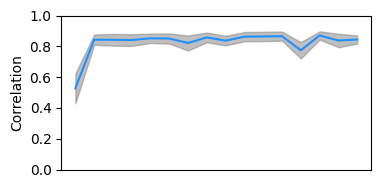

In [50]:
with PdfPages('correlation_date.pdf') as pdf:
    plt.figure(figsize=(4, 2))
    sns.lineplot(x = range(16),
                y = mean,
                color = '#1E90FF')
    plt.fill_between(x = range(16), y1 = mean - std, y2 = mean + std, color='gray', alpha=0.5)
    plt.ylim(0, 1)
    plt.xticks([])
    plt.ylabel("Correlation")
    pdf.savefig()
    plt.show()

In [51]:
from scipy.stats import ttest_ind

difference_df = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        if i == j:
            difference_df[i, j] = 1
        else:
            _, difference_df[i, j] = ttest_ind(correlation_df.iloc[:, i], correlation_df.iloc[:, j])

difference_df = np.log10(difference_df)

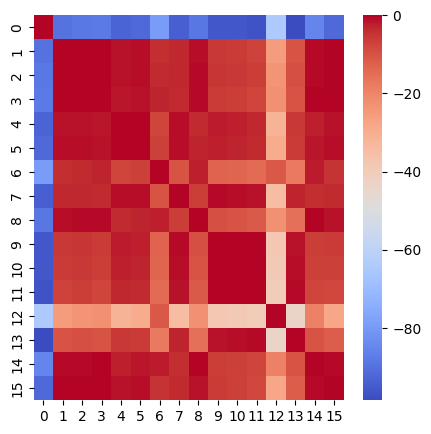

In [52]:
with PdfPages('correlation_p_value.pdf') as pdf:
    plt.figure(figsize=(5,5))
    sns.heatmap(difference_df,cmap="coolwarm",
                cbar=None)
    pdf.savefig()

    sns.heatmap(difference_df,cmap="coolwarm")
    pdf.savefig()


In [53]:
image_pv_df = pd.DataFrame()
for i in range(1, 118):
    image_pv_df = pd.concat((image_pv_df, firing_rate_dict['012123'][i].mean(axis = 1)), axis=1)

In [54]:
image_similarity = np.zeros((117, 117))
for i in range(117):
    for j in range(117):
        image_similarity[i, j], _ = pearsonr(image_pv_df.iloc[:, i], image_pv_df.iloc[:, j])

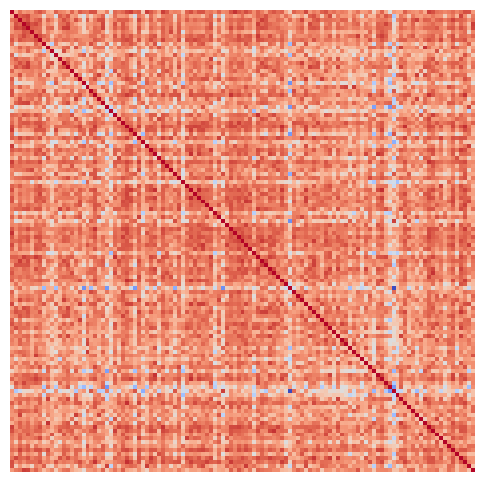

In [55]:
with PdfPages('PV_similarity_image.pdf') as pdf:
    plt.figure(figsize=(6,6))
    sns.heatmap(image_similarity, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=False)
    pdf.savefig()

In [56]:
pd.DataFrame(image_similarity).to_csv("image_similarity.csv")

In [57]:
cluster_inf.to_csv("cluster_inf_refine.tsv", index=False, sep='\t')

In [14]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["#FF0000", "#FF7F00", "#FFFF00", "#00FF00", "#0000FF", "#4B0082", "#9400D3"]
cmap = LinearSegmentedColormap.from_list("rainbow", colors)
num_colors = 18
rainbow_colors = cmap(np.linspace(0, 1, num_colors))

In [18]:
rainbow_colors = [
    '#e77888', '#e87b4d', '#cb8d42', '#b69844', '#a39e44', '#8da546',
    '#69ad47', '#5aae78', '#5aab93', '#5aaba4', '#5aa9b4', '#59a7c7',
    '#59a4e7', '#8c97ee', '#b389ed', '#d973ed', '#e470ce', '#e675ac'
]

In [19]:
with PdfPages('cluster_view_sep.pdf') as pdf:
    num = 0
    for neuron in select_neurons:
        temp = cluster_inf[cluster_inf['Neuron'] == neuron]
        waveform_mean_temp = waveform_mean.loc[:, temp['cluster_date'].tolist()]

        

        fig, ax = plt.subplots(figsize=(6, 4))
        for i in range(waveform_mean_temp.shape[1]):
            offset = 15
            sns.lineplot(x = range(61),
                        y = waveform_mean_temp.iloc[:, i] - offset * i,
                        color=rainbow_colors[num],
                        alpha = 0.4 + 0.02 * i,
                        ax=ax)
            
        num += 1
        ax.set_ylabel("Amplitude")
        ax.set_xticks([])
        ax.set_title(neuron)
        pdf.savefig(fig)
        plt.close(fig)